# Importing Libraries

In [2]:
import mne
import pathlib
import pandas as pd

# import asrpy
import numpy as np
import matplotlib.pyplot as plt

from mne.time_frequency import tfr_morlet

In [3]:
mne.utils.set_config('MNE_USE_CUDA', 'true')  

In [4]:
data_dir = "../"
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('..')

# Extracting files

In [13]:
types = 'think2'
FILES = list(data_dir.glob(f"sub-*/eeg/*{types}*.bdf"))

# Extracting raw data using MNE

In [14]:
%%capture
newfiles = []
for f in FILES:
    try:
        raw = mne.io.read_raw_bdf(f,preload=True)
        total_time_sec = raw.times[-1] - raw.times[0]
        if total_time_sec >= 600:
            newfiles.append(f)
    except:
        print("hi")

In [7]:
import re
filesHTR, filesCTR, filesVIP, filesSNY = [],[],[],[]
for f in newfiles:
    numbers = re.findall(r'\d+', str(f))
    numbers = [int(num) for num in numbers]
    n = numbers[0]
    if n <= 24:
        filesHTR.append(f)
    elif n <= 55 and n>24:
        filesCTR.append(f)
    elif n <= 78 and n>=60:
        filesVIP.append(f)
    else:
        filesSNY.append(f)

In [8]:
print(len(filesHTR),len(filesCTR),len(filesVIP),len(filesSNY))

13 31 14 19


In [11]:
filespaths = [f'./data/files/{types}HTR.txt',f'./data/files/{types}CTR.txt',f'./data/files/{types}VIP.txt',f'./data/files/{types}SNY.txt']
lists = [filesHTR,filesCTR,filesVIP,filesSNY]

In [ ]:
for path in filespaths:
    with open(path,'w') as file:
        

In [10]:
numberOfFiles = 10

# Compute the number of elements to delete
a = len(filesHTR) - numberOfFiles
b = len(filesCTR) - numberOfFiles
c = len(filesVIP) - numberOfFiles
d = len(filesSNY) - numberOfFiles

# Use slicing to remove elements
filesHTR = filesHTR[a:] if a > 0 else filesHTR
filesCTR = filesCTR[b:] if b > 0 else filesCTR
filesVIP = filesVIP[c:] if c > 0 else filesVIP
filesSNY = filesSNY[d:] if d > 0 else filesSNY

In [11]:
print(len(filesHTR),len(filesCTR),len(filesVIP),len(filesSNY))

10 10 10 10


In [12]:
%%capture
FILES = filesHTR + filesCTR + filesVIP + filesSNY
rawData = []
for f in FILES:
    raw = mne.io.read_raw_bdf(f,preload=True)
    rawData.append(raw)

# Dropping Channels

In [13]:
rawDropped = []
for i in range(40):
    n = rawData[i].info['ch_names']
    if(len(n)==73):
        rawDropped.append(rawData[i].drop_channels(n[-9:]))
    elif(len(n)==80):
        rawDropped.append(rawData[i].drop_channels(n[-16:]))
    else:
        rawDropped.append(rawData[i])

# Trimming

In [14]:
start_time = 0  # start time in seconds
end_time = 600    # end time in seconds
rawTrimmedData = []
for raw in rawDropped:
    raw_trimmed = raw.copy().crop(tmin=start_time, tmax=end_time)
    rawTrimmedData.append(raw_trimmed)

# DownSampling

In [15]:
%%capture
# Downsample the data to 256 Hz
fs_new = 256  # New sampling frequency in Hz
rawDownSampled = []
for raw in rawTrimmedData:
    raw_ds = raw.resample(fs_new, n_jobs='cuda')
    rawDownSampled.append(raw_ds)

# Filtering

In [16]:
# Preprocessing
# Cleaning the entire EEG 
def get_filtered_eeg(raw):
    low_freq = 0.3
    high_freq = 100.0

    raw_filtered = raw.copy().notch_filter(freqs=50)

    # Apply the bandpass filter
    raw_filtered = raw_filtered.filter(l_freq=low_freq, h_freq=high_freq, fir_design='firwin', n_jobs=20)

    #ASR cleaning with cutoff=20
    # asr = asrpy.ASR(sfreq=raw.info["sfreq"], cutoff=20)
    # asr.fit(raw_filtered)
    # raw_filtered = asr.transform(raw_filtered)

    ica = mne.preprocessing.ICA(n_components=15, max_iter="auto", random_state=97)
    ica.fit(raw_filtered)

    # # ica.plot_components()

    ica.exclude = []
    # find which ICs match the EOG pattern; no EOG attached, Taking Fp1 as proxy
    eog_indices, eog_scores = ica.find_bads_eog(raw_filtered,ch_name="Fp1")
    ica.exclude = eog_indices
    ica.apply(raw_filtered)
    return raw_filtered

In [17]:
%%capture
rawFiltered = []
for raw in rawDownSampled:
    rawFiltered.append(get_filtered_eeg(raw.copy()))

In [18]:
channels = rawFiltered[0].info["ch_names"]
np.array(channels)

array(['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3',
       'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1',
       'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz',
       'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4',
       'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4',
       'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8',
       'P10', 'PO8', 'PO4', 'O2'], dtype='<U3')

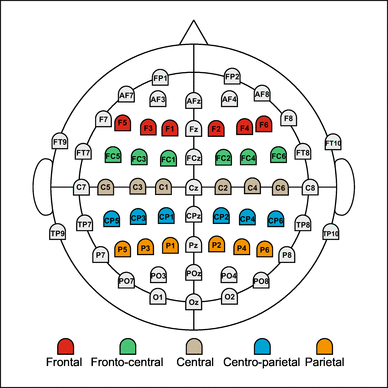

In [19]:
# Electrode placement

img_path = "../images/brain_electrodes.png"
from PIL import Image
Image.open(img_path)

# Epoch Parameters 

In [20]:
# Generate continuous data (e.g., a sine wave for simplicity)
fs = 256  # Sampling frequency in Hz
duration = 600  # Duration in seconds
# Define epoch parameters
epoch_length = 5  # in seconds
events = np.array([[i * epoch_length * fs, 0, 1] for i in range(duration // epoch_length)])
event_id = 1
tmin, tmax = 0, epoch_length  # Epoch start and end times

# Define Morlet wavelet parameters
frequencies = np.arange(8, 30, 1)  # Frequencies of interest from 1 to 50 Hz
n_cycles = frequencies / 2.  # Number of cycles in Morlet wavelet

In [21]:
epoch = mne.Epochs(rawFiltered[0], events, event_id, tmin, tmax, baseline=None, preload=True)

Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 120 events and 1281 original time points ...
1 bad epochs dropped


# Method-1 : Averaging the signal 

In [22]:
# %%capture
# powerD = []
# itcD = []
# phaseD = []
# for j in range(16):
#     # creating epochs
#     epochs = mne.Epochs(rawFiltered[j], events, event_id, tmin, tmax, baseline=None, preload=True)
#     # Compute power and phase
#     power,itc = mne.time_frequency.tfr_morlet(epochs, freqs=frequencies, n_cycles=n_cycles, use_fft=True, output='power',return_itc=True, n_jobs=20)
#     # complex_signal = mne.time_frequency.tfr_array_morlet(epochs, sfreq=fs, freqs=frequencies, n_cycles=n_cycles,use_fft=True, output='complex', n_jobs=20)
#     # phase = np.angle(complex_signal)   
#     powerD.append(power)
#     itcD.append(itc)
#     # phaseD.append(phase)

# Method-2 : Averaging over different Subjects

### Creating Epochs

In [23]:
%%capture
epochsList = []
for i in range(40):
    epochs = mne.Epochs(rawFiltered[i], events, event_id, tmin, tmax, baseline=None, preload=True)
    epochsList.append(epochs)

### Creating Trials

In [24]:
%%capture
trialsListHTR,trialsListCTR,trialsListVIP,trialsListSNY = [],[],[],[]
for i in range(119):
    trials = [[] for _ in range(4)]
    for j in range(10):
        epoch0 = epochsList[j][i]
        trials[0].append(epoch0)
        epoch1 = epochsList[j+10][i]
        trials[1].append(epoch1)
        epoch2 = epochsList[j+20][i]
        trials[2].append(epoch2)
        epoch3 = epochsList[j+30][i]
        trials[3].append(epoch3)
    trialsListHTR.append(trials[0])
    trialsListCTR.append(trials[1])
    trialsListVIP.append(trials[2])
    trialsListSNY.append(trials[3])

In [25]:
%%capture
combinedEpochsHTR,combinedEpochsCTR,combinedEpochsVIP,combinedEpochsSNY = [],[],[],[]
for i in range(119):
    # Converting into Epoch object
    combinedEpochsHTR.append(mne.concatenate_epochs(trialsListHTR[i]))
    combinedEpochsCTR.append(mne.concatenate_epochs(trialsListCTR[i]))
    combinedEpochsVIP.append(mne.concatenate_epochs(trialsListVIP[i]))
    combinedEpochsSNY.append(mne.concatenate_epochs(trialsListSNY[i]))

In [26]:
print(len(combinedEpochsHTR))
combinedEpochsHTR[0]

119


Number of events,10
Events,1: 10
Time range,0.000 – 5.000 s
Baseline,off


In [ ]:
powerD = [[] for _ in range(4)]

In [27]:
%%capture
itcDHTR = []
for i in range(119):
    _, itc = tfr_morlet(combinedEpochsHTR[i], freqs=frequencies, n_cycles=n_cycles, use_fft=True,output='power',return_itc=True, n_jobs=-1) 
    itcDHTR.append(itc)

In [28]:
%%capture
itcDCTR = []
for i in range(119):
    _, itc = tfr_morlet(combinedEpochsCTR[i], freqs=frequencies, n_cycles=n_cycles, use_fft=True,output='power',return_itc=True, n_jobs=-1) 
    itcDCTR.append(itc)

In [29]:
%%capture
itcDVIP = []
for i in range(119):
    _, itc = tfr_morlet(combinedEpochsVIP[i], freqs=frequencies, n_cycles=n_cycles, use_fft=True,output='power',return_itc=True, n_jobs=-1) 
    itcDVIP.append(itc)

In [33]:
%%capture
itcDSNY = []
for i in range(119):
    _, itc = tfr_morlet(combinedEpochsSNY[i], freqs=frequencies, n_cycles=n_cycles, use_fft=True,output='power',return_itc=True, n_jobs=-1) 
    itcDSNY.append(itc)

In [31]:
type(itcDSNY[0].data)

numpy.ndarray

In [1]:
from smallScripts.distance_matrix import get_plv_dm 

In [2]:
itcData = [itcDHTR,itcDCTR,itcDVIP,itcDSNY]
dm = get_plv_dm(itcD=itcData)

NameError: name 'itcDHTR' is not defined

In [44]:
# channelsOfInterest = ['Fp1','Fp2','Fz', 'P1', 'P2', 'Pz']
# # Select a specific channel and time-frequency data for plotting
# for i in range(6):
#     channel_name = channelsOfInterest[i]
#     channel_index = epoch.ch_names.index(channel_name)
#     power_data = powerD2[0].data[channel_index] # Select the channel
#     # phase_data = phaseD[0][0, channel_index, :, :]
#     itc_data = itcD2[0].data[channel_index]

#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))

#     # Plot the power data
#     im1 = ax1.imshow(power_data, aspect='auto', origin='lower',
#                      extent=[epoch[0].times[0], epoch[0].times[-1], frequencies[0], frequencies[-1]],
#                      cmap='RdBu_r')
#     fig.colorbar(im1, ax=ax1, label='Power')
#     ax1.set_xlabel('Time (s)')
#     ax1.set_ylabel('Frequency (Hz)')
#     ax1.set_title(f'Time-Frequency Representation for Channel {channel_name} Power')

#     # Plot the ITC data
#     im2 = ax2.imshow(itc_data, aspect='auto', origin='lower',
#                      extent=[epoch[0].times[0], epoch[0].times[-1], frequencies[0], frequencies[-1]],
#                      cmap='viridis')
#     fig.colorbar(im2, ax=ax2, label='ITC')
#     ax2.set_xlabel('Time (s)')
#     ax2.set_ylabel('Frequency (Hz)')
#     ax2.set_title('Time-Frequency Representation for Channel {channel_name} Phase')

#     plt.tight_layout()
#     plt.show()

In [1]:
# # itcD is data array
# data = itcDHTR[100].data  # Shape: (64, 22, 2561)

# # Reshape data to (electrodes, features) where features are frequency-time combinations
# reshaped_data = data.reshape(data.shape[0], -1)

# # Compute the correlation matrix
# correlation_matrix = np.corrcoef(reshaped_data)

# # Define electrode names
# channel_names = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']

# # Plot the correlation matrix with electrode names
# plt.figure(figsize=(30, 20))
# plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
# plt.colorbar()
# plt.title('Electrode Phase Correlation Matrix')
# plt.xticks(np.arange(len(channel_names)), channel_names, rotation=90)
# plt.yticks(np.arange(len(channel_names)), channel_names)
# plt.xlabel('Electrodes')
# plt.ylabel('Electrodes')
# plt.show()


In [29]:
dm = [[] for _ in range(4)]
for i in range(119):
    data1 = itcDHTR[i].data  # Shape: (64, 22, 2561)
    data2 = itcDCTR[i].data
    data3 = itcDVIP[i].data
    data4 = itcDSNY[i].data

    # Reshape data to (electrodes, features) where features are frequency-time combinations
    reshaped_data1 = data1.reshape(data1.shape[0], -1)
    reshaped_data2 = data2.reshape(data2.shape[0], -1)
    reshaped_data3 = data3.reshape(data3.shape[0], -1)
    reshaped_data4 = data4.reshape(data4.shape[0], -1)

    # Compute the correlation matrix
    correlation_matrix1 = np.corrcoef(reshaped_data1)
    correlation_matrix2 = np.corrcoef(reshaped_data2)
    correlation_matrix3 = np.corrcoef(reshaped_data3)
    correlation_matrix4 = np.corrcoef(reshaped_data4)
    
    dm[0].append(1-correlation_matrix1)
    dm[1].append(1-correlation_matrix2)
    dm[2].append(1-correlation_matrix3)
    dm[3].append(1-correlation_matrix4)

In [58]:
len(dm[0])

119

In [35]:
paths = ['./data/Distance-Matrix/think2/HTR/','./data/Distance-Matrix/think2/CTR/','./data/Distance-Matrix/think2/VIP/','./data/Distance-Matrix/think2/SNY/']
for i,path in enumerate(paths):
    for j in range(119):
        pd.DataFrame(dm[i][j]).to_csv(path + f'DmEpoch{j}.csv',index=False)

In [39]:
# paths = ['./data/Distance-Matrix/think2/HTR/','./data/Distance-Matrix/think2/CTR/','./data/Distance-Matrix/think2/VIP/','./data/Distance-Matrix/think2/SNY/']
# for i,path in enumerate(paths):
#     paths[i] = pathlib.Path(path)
# # read distance matrices
# distance_matricesHTR,distance_matricesCTR,distance_matricesVIP,distance_matricesSNY = [],[],[],[]
# for i in range(4):
#     files = list(paths[i].glob('*.csv'))
#     for j in range(119):
#         files[j] = str(files[j])
#     if(i==0):
#         distance_matricesHTRf=files
#     elif(i==1):
#         distance_matricesCTRf=files
#     elif(i==2):
#         distance_matricesVIPf=files
#     else:
#         distance_matricesSNYf=files

# import re
# # Function to extract the number from the string
# def extract_number(s):
#     match = re.search(r'DmEpoch(\d+)\.csv', s)
#     return int(match.group(1))  # Handle cases where there is no number

# # Sort the list using the custom key
# distance_matricesHTRf = sorted(distance_matricesHTRf, key=extract_number)
# distance_matricesCTRf = sorted(distance_matricesCTRf, key=extract_number)
# distance_matricesVIPf = sorted(distance_matricesVIPf, key=extract_number)
# distance_matricesSNYf = sorted(distance_matricesSNYf, key=extract_number)

# dmf = [distance_matricesHTRf,distance_matricesCTRf,distance_matricesVIPf,distance_matricesSNYf]

# for i,files in enumerate(dmf):
#     df119 = []
#     for file in files:
#         df = pd.read_csv(file).to_numpy()
#         df119.append(df)
#     if(i==0):
#         distance_matricesHTR = df119
#     elif(i==1):
#         distance_matricesCTR = df119
#     elif(i==2):
#         distance_matricesVIP = df119
#     else:
#         distance_matricesSNY = df119

# dm = [distance_matricesHTR,distance_matricesCTR,distance_matricesVIP,distance_matricesSNY]

In [40]:
print(len(dm), len(dm[0]), dm[0][0].shape)

4 119 (64, 64)


# TDA

In [41]:
import gudhi as gd
PERSISTENCES = [[] for _ in range(4)]
for k in range(4):
    for i in range(119):
        # Convert the distance matrix to a format that Gudhi can use
        rips_complex = gd.RipsComplex(distance_matrix=dm[k][i], max_edge_length=1)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
        # Compute the persistence diagram
        persistence = simplex_tree.persistence()
        PERSISTENCES[k].append(persistence)

In [42]:
print(len(PERSISTENCES), len(PERSISTENCES[0]))

4 119


In [43]:
from collections import defaultdict
radii = np.linspace(0, 1, 100)
def get_betti_numbers(persistence, max_dim=2):
    betti_numbers = defaultdict(list)
    for radius in radii:
        counts = [0] * (max_dim + 1)
        for interval in persistence:
            dim = interval[0]
            birth, death = interval[1]
            if birth <= radius < death:
                counts[dim] += 1
        for dim in range(max_dim + 1):
            betti_numbers[dim].append(counts[dim])
    return betti_numbers

BETTI = [[] for _ in range(4)]
for k in range(4):
    for i in range(119):
        betti_numbers = get_betti_numbers(PERSISTENCES[k][i])
        BETTI[k].append(betti_numbers)

In [44]:
len(BETTI[3])

119

In [45]:
# Calculate the area under the curve using the trapezoidal rule
areaHTR,areaCTR,areaVIP,areaSNY = [],[],[],[]
for i in range(119):
    area1 = np.trapz(BETTI[0][i][0], radii)
    area2 = np.trapz(BETTI[1][i][0], radii)
    area3 = np.trapz(BETTI[2][i][0], radii)
    area4 = np.trapz(BETTI[3][i][0], radii)
    areaHTR.append(area1)
    areaCTR.append(area2)
    areaVIP.append(area3)
    areaSNY.append(area4)

In [46]:
total_area = [areaHTR, areaCTR, areaVIP, areaSNY]

In [47]:
radii5percent = [[] for _ in range(4)]
betti5percent = [[] for _ in range(4)]
for k in range(4):
    for j in range(119):
        for i in range(len(radii)):
            area = np.trapz(BETTI[k][j][0][:i],radii[:i])
            if (area >= 0.95*total_area[k][j]):
                radii5percent[k].append(radii[i])
                betti5percent[k].append(BETTI[k][j][0][i])
                break

In [48]:
DFs = [pd.DataFrame() for _ in range(4)]

for i in range(4):
    DFs[i]['area'] = total_area[i]
    DFs[i]['radii5'] = radii5percent[i]
    DFs[i]['betti5'] = betti5percent[i]

In [49]:
DFs[0].to_csv('./data/Topographical-features/think2/dfHTR.csv', index=False)
DFs[1].to_csv('./data/Topographical-features/think2/dfCTR.csv', index=False)
DFs[2].to_csv('./data/Topographical-features/think2/dfVIP.csv', index=False)
DFs[3].to_csv('./data/Topographical-features/think2/dfSNY.csv', index=False)